In [1]:
from models import * 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from create_word_vectors import * 
import pickle 
import helper
from tfidf_methods import * 
from paths import * 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import *
from sklearn.svm import  *
from sklearn import *
from sklearn.model_selection import *
from sklearn.naive_bayes import MultinomialNB
import re

%matplotlib inline

Using TensorFlow backend.


In [ ]:
# Prepare glove embedding mazrix and save it in embeddings
X_sequences, y, Kgl_sequences, nb_word , word_embedding, glove_matrix = run_glove_embbedding(GLOVE_EMBEDDING
                                        + "emebddings.pkl", n_grams = 1, pretrained = True, max_words = None)

In [3]:
# Read cleaned files! we will not always perform 
X = pickle.load(open(CLEANED_DATA_PATH + 'X_Cleaned.pkl', "rb"))
X_Kgl = pickle.load(open(CLEANED_DATA_PATH + 'X_Kgl_Cleaned.pkl', "rb"))

In [4]:
# Prepare tfidf embedding
X_train_tfidf_avg, X_test_tfidf_avg, X_train_tfidf, X_test_tfidf = tfidf_embedding(X, X_Kgl, word_embedding)

train tfidf
average word vector
test tfidf
average word vector


In [5]:
seed = 0
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf_avg, y, test_size = 0.2, random_state = seed, stratify=y)

### Define Cross-Validation Schema and Baseline


In [6]:
# Define a baseline using dummey classifier
# It enables you to define a basic classifier which apply simple strategies such as stratified
# Stratified strategy predicts probability of belonging to positive class as percentage of positive cases

from sklearn.dummy import DummyClassifier

seed = 0
dummy_clf = DummyClassifier(strategy='stratified',random_state = seed)
dummy_clf.fit(X_train,y_train)
baseline_score = dummy_clf.score(X_test,y_test)
print (baseline_score)

0.499216


# Other models with pipeline 

In [15]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import *
from sklearn.svm import  *
from sklearn import *
import numpy as np
from sklearn.model_selection import *
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from  sklearn.metrics import accuracy_score

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

def  other_models(x):
    clf1 = LogisticRegression()
    clf2 = LinearSVC()
    clf3 = RidgeClassifier()
    clf4 = PassiveAggressiveClassifier()

    y = np.array(1250000 * [0] + 1250000 * [1])

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('rcs', clf3), ('pac', clf4)], voting='hard')

    for clf, label in zip([clf1, clf2, clf3, clf4, eclf], ['Logistic Regression', 'Linear SVC', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
      
        checker_pipeline = Pipeline([
                ('classifier', clf)
            ])
        clf_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)

        print ("Validation result for {}".format(label))
        print(clf_accuracy)

In [16]:
other_models(X_train_tfidf_avg)

Validation result for Logistic Regression
0.755562
Validation result for Linear SVC
0.754328
Validation result for Ridge Classifier
0.745474
Validation result for Passive Aggresive Classifier
0.632484
Validation result for Ensemble
0.754536


In [17]:
other_models(X_train_tfidf)

Validation result for Logistic Regression
0.815624
Validation result for Linear SVC
0.81445
Validation result for Ridge Classifier
0.813898
Validation result for Passive Aggresive Classifier
0.786406
Validation result for Ensemble
0.815008


In [33]:
X__tfidf_avg = [0.755562, 0.754328, 0.745474, 0.632484, 0.754536]

In [34]:
X_tfidf = [0.815624, 0.81445, 0.813898, 0.786406, 0.815008]

In [86]:
df = pd.DataFrame(columns = ['X_tfidf_avg', 'X_tfidf'])
df['X_tfidf_avg'] = X__tfidf_avg
df['X_tfidf'] = X_tfidf
df['models'] = [' Logistic Regression', 'Linear SVC', 'Ridge Classifier', 'Passive Aggresive', 'Ensemble']

In [103]:
df = df.sort_values(['X_tfidf_avg'])

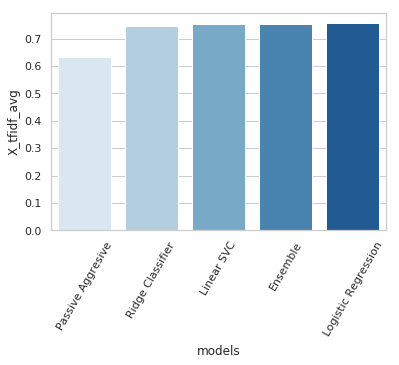

In [107]:
pal = sns.color_palette("Greens_d", 5)
ax = sns.barplot(x="models", y="X_tfidf_avg", data=df,palette='Blues')
ax.set_xticklabels(df["models"], rotation=60)

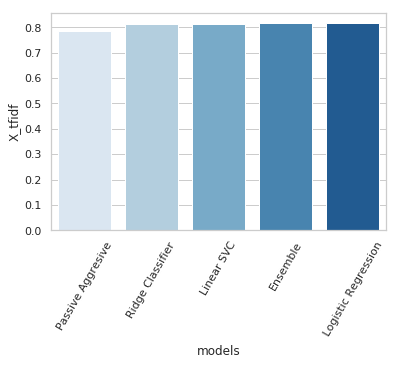

In [108]:
ax = sns.barplot(x="models", y="X_tfidf", data=df,palette='Blues')
ax.set_xticklabels(df["models"], rotation=60)

###  Since the logistic regression gave us the best accuracy with tf_idf data we will tune it hyper parameters

In [111]:
# Separate target and features into test and training and validation sets
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size = 0.2, random_state = seed, stratify=y)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = seed)

In [ ]:
# Remove the ''' to tune the C parameter
estimators = []
estimators.append(('lr_clf', LogisticRegression()))
pipeline = Pipeline(estimators)

# Finding best value of C using validation set
scores = []
Cs = []
for C in np.logspace(-4, 5, 10):
    pipeline.set_params(lr_clf__C=C) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict(X_train_val)
    scores.append(accuracy_score(y_train_val, y_train_pred))
    Cs.append(C)

best_C = Cs[scores.index(max(scores))]

In [129]:
estimators = []
estimators.append(('lr_clf', LogisticRegression()))
pipeline = Pipeline(estimators)
pipeline.set_params(lr_clf__C=1)
pipeline.fit(X_train,y_train)
y_pred_lr = pipeline.predict(X_test)

In [131]:
accuracy_score(y_test, y_pred_lr)

### Training on neural network 

In [145]:
# create LSTM
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Sequential

num_samples = X_train_tfidf_avg.shape[0]
num_vals    = X_train_tfidf_avg.shape[1]
X_train = np.reshape(X_train_tfidf_avg, (num_samples, num_vals, 1))


model = Sequential()
model.add(LSTM(6, input_shape=(num_vals, 1), return_sequences=True))
model.add(LSTM(6))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y,
  epochs=2,
  verbose=1,
  validation_split=0.1,
  shuffle=True)